# Model-Free Prediction and Control

#### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "Courier New"
import copy

from maze_class import Maze
from monte_carlo import *
from td_learning import *
from plot_functions import plot_grid, q_table, plot_q_table

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Monte Carlo

#### Initialise parameters

In [2]:
MAX_EP = 3000
STEP_COST = -0.1
MAX_EP_LEN = 30

maze_coords = {
    "[0, 0]": 0, "[0, 1]": 1, "[0, 2]": 2, "[0, 3]": 3,
    "[1, 0]": 4, "[1, 1]": 5, "[1, 2]": 6, "[1, 3]": 7,
    "[2, 0]": 8, "[2, 1]": 9, "[2, 2]": 10, "[2, 3]": 11,
    "[3, 0]": 12, "[3, 1]": 13, "[3, 2]": 14, "[3, 3]": 15
}

reversed_maze = {
    "0": [0, 0], "1": [0, 1], "2": [0, 2], "3": [0, 3],
    "4": [1, 0], "5": [1, 1], "6": [1, 2], "7": [1, 3],
    "8": [2, 0], "9": [2, 1], "10": [2, 2], "11": [2, 3],
    "12": [3, 0], "13": [3, 1], "14": [3, 2], "15": [3, 3],
}

#### Evironment

In [3]:
env = Maze(maze_coords,reversed_maze, step_cost=STEP_COST, max_ep_length=MAX_EP_LEN)

#### Visualize rewards

#### Factor 1

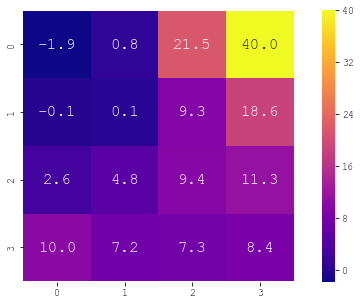

In [4]:
policy_eval1 = mc_evaluation_policy(env, discount_factor=1)
plot_grid(policy_eval1.reshape((4,4)))

#### Factor 0.9

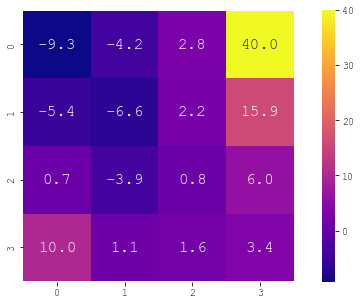

In [5]:
policy_eval2 = mc_evaluation_policy(env, discount_factor=0.9)
plot_grid(policy_eval2.reshape((4,4)))

## TD Learning

#### Factor 1

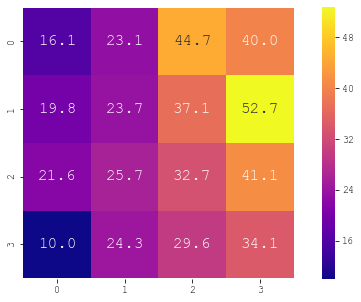

In [6]:
policy_eval1 = td_learning(env, discount_factor=1)
plot_grid(policy_eval1.reshape((4,4)))

#### Factor 0.9

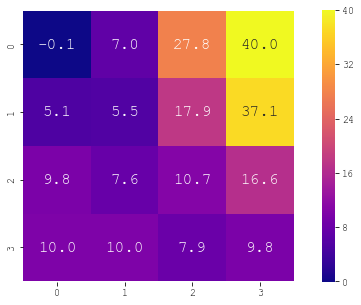

In [7]:
policy_eval2 = td_learning(env, discount_factor=0.9)
plot_grid(policy_eval2.reshape((4,4)))

## On-policy first-visit Monte-Carlo Control

#### Initialize rewards lists 

In [8]:
rewards = rewards_lists(16,4)

#### Visualize Q-Table

#### Factor 1

In [9]:
# Factor 1
grid_values = first_visit_mc(env=env, max_ep=MAX_EP, discount_factor=1, rewards=rewards)
print(grid_values)

[[18.         27.3        39.5        23.98333333]
 [15.86666667 38.63939394  0.         32.86666667]
 [38.55       40.         39.77777778 24.1       ]
 [40.         40.         40.         40.        ]
 [29.14444444 38.54285714 24.7        28.275     ]
 [25.22       39.49678457 36.72       33.55357143]
 [38.41428571 39.79319287 39.625      38.90681818]
 [40.         39.85166667 39.72134831 39.68138298]
 [39.26363636 35.98571429 10.         27.06      ]
 [37.84622951 38.22352941 33.73076923 33.81034483]
 [39.60311111 39.63325207 38.14655172 37.25792683]
 [39.85102143 39.71103448 39.35838926 38.77515528]
 [10.         10.         10.         10.        ]
 [36.85       29.69230769 34.52352941 10.        ]
 [39.30437158 39.17432432 37.72417062 33.28510638]
 [39.68511236 39.4        35.8        36.55217391]]


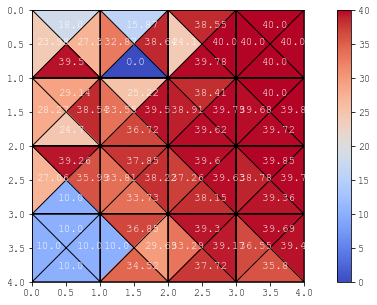

In [10]:
plot_q_table(grid_values)

#### Factor 0.99

In [11]:
# Factor 0.9
grid_values_2 = first_visit_mc(env=env, max_ep=MAX_EP, discount_factor=0.9, rewards=rewards)
print(grid_values_2)

[[ -0.89969338   2.11148236  13.93530182   0.        ]
 [-10.64778488  35.81309203   0.           0.74256967]
 [ 25.72962931  40.          32.54789369  22.53300769]
 [ 40.          40.          40.          40.        ]
 [  5.85414489  30.85663215   6.63843573  27.80002   ]
 [ 12.64431436  35.18736623  26.3939078   23.38890947]
 [ 33.82290017  37.26427867  32.38043934  32.53271171]
 [ 40.          37.39362188  34.45809616  34.42689406]
 [ 21.58402832  27.70923435   0.          19.07693737]
 [ 30.74119973  30.69562236  26.87967721  27.34782464]
 [ 34.44734529  34.47365469  30.02009541  28.81851525]
 [ 37.09555096  34.55111863  31.90372995  31.67100031]
 [ 10.          10.          10.          10.        ]
 [ 29.87527846  26.57446154  24.97573715  10.        ]
 [ 32.34757035  32.31532938  29.83961837  24.95441275]
 [ 34.68181853  30.20068931  30.63206572  28.21293167]]


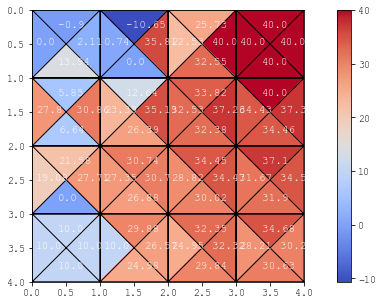

In [12]:
plot_q_table(grid_values_2)

## SARSA

#### Visualize maze rewards

#### Factor 1 

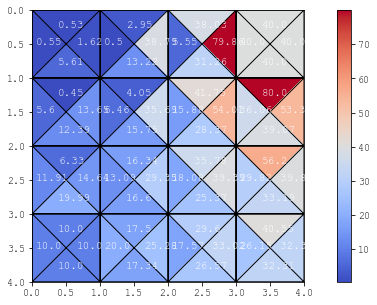

In [13]:
sarsa_1 = sarsa(env=env, discount_factor=1, alpha=0.01)
print(sarsa_1)
plot_q_table(sarsa_1)

#### Factor 0.9

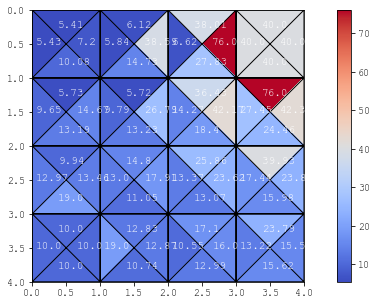

In [14]:
sarsa_2 = sarsa(env=env, discount_factor=0.9, alpha=0.01)
print(sarsa_2)
plot_q_table(sarsa_2)

## SARSAMAX, Q-Learning

#### Factor 1

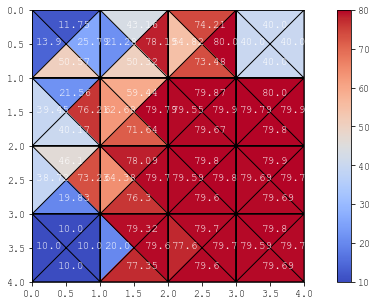

In [15]:
sarsaMAX1 = sarsaMAX(env=env, discount_factor=1, alpha=0.01)
print(sarsaMAX1)
plot_q_table(sarsaMAX1)

#### Factor 0.9

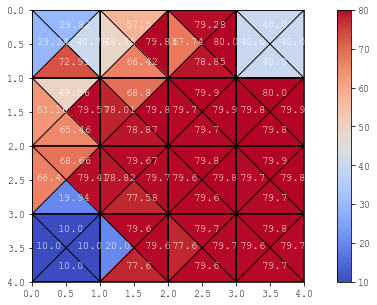

In [16]:
sarsaMAX2 = sarsaMAX(env=env, discount_factor=1, alpha=0.01)
print(sarsaMAX2)
plot_q_table(sarsaMAX2)